# Sensitivity to Noise

## Prepare the dataset

In [1]:
# #!/usr/bin/env python3
# """
# Noise-sensitivity sweep for eight precipitation downscaling models.

# • Adds Gaussian noise (σ ∈ [0.1, 1.0], 20 linearly-spaced steps) to channel-1.
# • Computes MSE (vs each model’s own control prediction) and KGE (vs HR reference).
# • Saves a tidy results file:  noise_sensitivity_summary.csv
# """

# import os, time
# import numpy as np
# import pandas as pd
# import hydroeval as he
# from tensorflow.keras.models import load_model
# from ai4klima.tensorflow.utils import (
#     make_predictions, negtozero, r_logtrans
# )

# # ──────────────────────────────────────────────────────────────────────────────
# # Helpers
# # ──────────────────────────────────────────────────────────────────────────────
# def log(msg):
#     """Timestamped console print."""
#     print(f"{time.strftime('%H:%M:%S')}  {msg}", flush=True)

# # def kge(pred, obs, eps=1e-12):
# #     """Kling–Gupta Efficiency (Gupta et al., 2009)."""
# #     pred, obs = np.asarray(pred), np.asarray(obs)
# #     m = ~np.isnan(obs)
# #     pred, obs = pred[m], obs[m]
# #     r   = np.corrcoef(pred, obs)[0, 1]
# #     alpha = (pred.std(ddof=1)+eps) / (obs.std(ddof=1)+eps)
# #     beta  = (pred.mean()+eps)      / (obs.mean()+eps)
# #     return 1.0 - np.sqrt((r-1)**2 + (alpha-1)**2 + (beta-1)**2)

# # Define evaluation metrics functions
# def kge(y_true, y_pred):
#     evaluations = y_true[~np.isnan(y_true)].flatten()
#     simulations = y_pred[~np.isnan(y_pred)].flatten()
#     kge, r, alpha, beta = he.evaluator(he.kgeprime, simulations, evaluations)
#     return kge[0]
    
# def clean(arr):
#     """Inverse-log-transform then set negatives → 0."""
#     return negtozero(r_logtrans(arr))

# # ──────────────────────────────────────────────────────────────────────────────
# # Data loader
# # ──────────────────────────────────────────────────────────────────────────────
# def loadstack_inputs(bounds=(6209, 7305), *,
#                      add_noise_ch1=False, add_noise_ch2=False,
#                      noise_stddev=0.1):
#     """Return [X_dyn, X_stat] ready for predict()  +  y_ref."""
#     DATA_PATH = ("/home/midhunm/AI4KLIM/EXPMNTS/P02A_DeepDown_Generalization/"
#                  "ANALYSE/PLTDATA/FM09_InputNoiseSensitivity/data")

#     log("Loading dynamic channels …")
#     ch1 = np.load(f"{DATA_PATH}/C01_080_IMRG_PREC_2001_2023_GMEAN_LOG.npy")
#     ch2 = np.load(f"{DATA_PATH}/C01_080_IMRG_DCLM_2001_2023_GMEAN_LOG.npy")

#     if add_noise_ch1:
#         log(f"Adding Gaussian noise to channel-1 (σ={noise_stddev:.3f})")
#         ch1 += np.random.normal(0.0, noise_stddev, ch1.shape)
#     if add_noise_ch2:
#         log(f"Adding Gaussian noise to channel-2 (σ={noise_stddev:.3f})")
#         ch2 += np.random.normal(0.0, noise_stddev, ch2.shape)

#     log("Loading static orography channel …")
#     static = np.load(f"{DATA_PATH}/C01_080_GTOP_ELEV_2001_2023_GMEAN_CLOG.npy")
#     static = np.expand_dims(static, axis=-1)

#     log("Loading reference HR precipitation …")
#     y_ref = np.load(f"{DATA_PATH}/C01_010_IMRG_PREC_2001_2023.npy")

#     sl = slice(bounds[0], bounds[1])
#     ch1, ch2  = ch1[sl], ch2[sl]
#     static    = static[sl]
#     y_ref     = y_ref[sl]

#     X_dyn  = np.stack([ch1, ch2], axis=-1)   # (t, H, W, 2)
#     X_stat = static                          # (t, H, W, 1)

#     log(f"Shapes → dyn:{X_dyn.shape}, stat:{X_stat.shape}, y:{y_ref.shape}")
#     return [X_dyn, X_stat], y_ref

# # ──────────────────────────────────────────────────────────────────────────────
# # Configuration
# # ──────────────────────────────────────────────────────────────────────────────
# MPATH = ("/home/midhunm/AI4KLIM/EXPMNTS/P02A_DeepDown_Generalization/"
#          "ANALYSE/PLTDATA/FM09_InputNoiseSensitivity/model_files")

# models_dict = {
#     'SRCNN' : "p02a_hp-b32-r7e4-wmae_e01_m00_b13_ckpt_best_gen.keras",
#     'FSRCNN': "p02a_hp-b32-r7e4-wmae_e01_m01_b13_ckpt_best_gen.keras",
#     'EDRN'  : "p02a_hp-b32-r7e4-wmae_e01_m02_b13_ckpt_best_gen.keras",
#     'SRDRN' : "p02a_hp-b32-r7e4-wmae_e01_m03_b13_ckpt_best_gen.keras",
#     'U-NET' : "p02a_hp-b32-r7e4-wmae_e01_m04_b13_ckpt_best_gen.keras",
#     'AU-NET': "p02a_hp-b32-r7e4-wmae_e01_m05_b13_ckpt_best_gen.keras",
#     'U-GAN' : "p02a_hp-b32-r7e4-wmae_e01_m07_b13_ckpt_best_gen.keras",
#     'AU-GAN': "p02a_hp-b32-r7e4-wmae_e01_m08_b13_ckpt_best_gen.keras",
# }
# models_dict = {k: os.path.join(MPATH, v) for k, v in models_dict.items()}

# # noise_grid = np.linspace(0.1, 1.0, 20)      # 20 values: 0.10 → 1.00
# noise_grid = np.arange(0.0, 0.21, 0.02)    # 0 → 0.20 in 0.02 steps
# # ──────────────────────────────────────────────────────────────────────────────
# # 1. Baseline predictions (σ = 0)
# # ──────────────────────────────────────────────────────────────────────────────
# log("════════════════════════  BASELINE RUN  ════════════════════════")
# X_base, y_ref = loadstack_inputs(add_noise_ch1=False)
# baseline_preds = {}

# for name, path in models_dict.items():
#     log(f"Loading model {name} …")
#     mdl = load_model(path, compile=False)
#     y_raw = make_predictions(mdl, X_base)   # log-space
#     baseline_preds[name] = clean(y_raw)     # physical units
#     log(f"{name} baseline prediction complete.")

# # ──────────────────────────────────────────────────────────────────────────────
# # 2. Noise sweep
# # ──────────────────────────────────────────────────────────────────────────────
# results = []
# for i, sigma in enumerate(noise_grid, 1):
#     log(f"════════════════════════  σ = {sigma:.3f}  "
#         f"({i}/{len(noise_grid)})  ═══════════════════════")
#     X_noisy, _ = loadstack_inputs(add_noise_ch1=True, noise_stddev=float(sigma))

#     for name, path in models_dict.items():
#         log(f"→ {name}")
#         mdl = load_model(path, compile=False)
#         y_hat = clean(make_predictions(mdl, X_noisy))

#         mse_val = np.mean((y_hat - baseline_preds[name])**2)
#         kge_val = kge(y_hat.ravel(), y_ref.ravel())
#         log(f"   MSE={mse_val:.4e}   KGE={kge_val:+.3f}")

#         results.append({
#             "model"          : name,
#             "sigma"          : round(float(sigma), 3),
#             "MSE_vs_control" : float(mse_val),
#             "KGE_vs_ref"     : float(kge_val),
#         })

# # ──────────────────────────────────────────────────────────────────────────────
# # 3. Save results
# # ──────────────────────────────────────────────────────────────────────────────
# df = pd.DataFrame(results).sort_values(["model", "sigma"])
# out_csv = "noise_sensitivity_summary.csv"
# df.to_csv(out_csv, index=False)

# log("══════════════  sweep finished — results written to "
#     f"{out_csv}  ══════════════")


## Make the Plot

/tmp/ipykernel_13918/531166649.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10 = get_cmap("tab10")                  # Matplotlib’s Tab10 palette


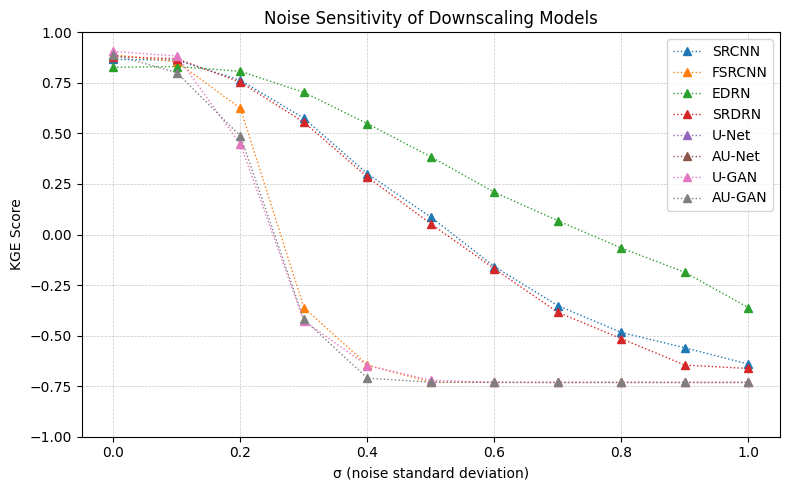

In [2]:
#!/usr/bin/env python3
"""
Plot KGE vs σ for all downscaling models.
"""

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# ------------------------------------------------------------------
# 1.  PATH TO YOUR RESULTS FILE
# ------------------------------------------------------------------
CSV_PATH = ("/home/midhunm/AI4KLIM/EXPMNTS/P02A_DeepDown_Generalization/"
            "ANALYSE/PLTDATA/FM08_InputNoiseSensitivity/"
            "noise_sensitivity_summary_noise_opt01.csv")

# ------------------------------------------------------------------
# 2.  READ + CLEAN DATA
# ------------------------------------------------------------------
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()        # trim stray spaces in headers

model_order = ["SRCNN", "FSRCNN", "EDRN", "SRDRN",
               "U-Net", "AU-Net", "U-GAN", "AU-GAN"]

# ensure categorical ordering for consistent legend / plotting
df["model"] = pd.Categorical(df["model"].str.strip(),
                             categories=model_order, ordered=True)

# ------------------------------------------------------------------
# 3.  PLOT WITH TAB10 COLORS
# ------------------------------------------------------------------
tab10 = get_cmap("tab10")                  # Matplotlib’s Tab10 palette
plt.figure(figsize=(8, 5))

for i, model in enumerate(model_order):
    sub = df[df["model"] == model].sort_values("sigma")
    plt.plot(sub["sigma"], sub["KGE_vs_ref"],
             marker="^", linewidth=1, linestyle= ':',
             color=tab10(i), label=model)

plt.xlabel("σ (noise standard deviation)")
plt.ylabel("KGE Score")
plt.title("Noise Sensitivity of Downscaling Models")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.ylim(-1, 1)

# --- optional: save instead of (or in addition to) showing
# plt.savefig("noise_sensitivity_kge.png", dpi=300)
plt.show()


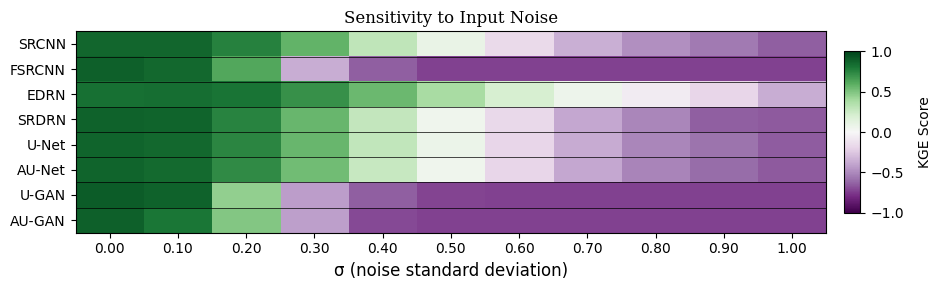

In [4]:
#!/usr/bin/env python3
"""
KGE heat-map (models × σ) with a vertical colour-bar and gray horizontal gridlines.
Scale: –1 (poor) → 0 (no skill) → +1 (perfect).
"""

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# ------------------------------------------------------------------
# 1 ▸ LOAD + CLEAN DATA
# ------------------------------------------------------------------

CSV_PATH = "/home/midhunm/AI4KLIM/EXPMNTS/P02A_DeepDown_Generalization/ANALYSE/PLTDATA/FM08_InputNoiseSensitivity/noise_sensitivity_summary_noise_opt01.csv"

df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()          # trim stray spaces in headers

model_order = ["SRCNN", "FSRCNN", "EDRN", "SRDRN",
               "U-Net", "AU-Net", "U-GAN", "AU-GAN"]
df["model"] = pd.Categorical(df["model"].str.strip(),
                             categories=model_order, ordered=True)

pivot = (df.pivot(index="model", columns="sigma", values="KGE_vs_ref")
           .loc[model_order])                # keep custom order

# ------------------------------------------------------------------
# 2 ▸ PLOT
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 3))

norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
cmap = plt.get_cmap("PRGn")

im = ax.imshow(pivot, aspect="auto", cmap=cmap,
               origin="upper", norm=norm)

# axis tick labels
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels([f"{s:.2f}" for s in pivot.columns],
                   rotation=0, ha="center")
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)

# Draw gray horizontal gridlines between rows
n_rows = len(pivot.index)
for i in range(n_rows + 1):
    y = i - 0.5
    ax.axhline(y, color="k", linewidth=0.5)

# vertical colour-bar
cbar = fig.colorbar(im,
                    ax=ax,
                    orientation="vertical",  # set vertical orientation
                    pad=0.02,                # distance from heat-map
                    shrink=0.8,              # bar length (fraction of axes height)
                    aspect=10)               # bar thickness
cbar.set_label("KGE Score", labelpad=10)

# titles & layout
ax.set_xlabel("σ (noise standard deviation)", fontsize=12,)
ax.set_title("Sensitivity to Input Noise", fontsize=12, fontfamily = 'serif')
plt.tight_layout()

SAVE_DIR = '/home/midhunm/AI4KLIM/EXPMNTS/P02A_DeepDown_Generalization/ANALYSE/RESULTS'
plt.savefig(f'{SAVE_DIR}/Figure08_NoiseSensitivity.jpg', format='jpg', dpi=500, bbox_inches='tight', facecolor='w')
plt.show()
